# Standard Neural Networks
## I) Multilayer Perceptron (MLP)
### A) Some of theory about Multilayer Perceptron (MLP)

A Multilayer Perceptron (MLP) is an extension of the basic perceptron, consisting of multiple layers of neurons organized in a hierarchical structure. Each layer in an MLP feeds into the next, enabling the network to capture more complex patterns in the data.

MLPs are composed of three types of layers:
- **Input Layer**: The first layer that receives the input features.
- **Hidden Layer(s)**: Intermediate layers where neurons process and transform the input data. These layers are not directly observable from the input or output, hence the term "hidden."
- **Output Layer**: The final layer that produces the output of the network.

Each neuron in a given layer is connected to all the neurons in the next layer, forming a fully connected (dense) network. These connections are associated with weights, which are adjusted during the training process.

#### Feedforward Process in MLP

The feedforward process in a Multilayer Perceptron is similar to that of a single-layer perceptron, but with multiple layers of transformations. In mathematical terms, for an MLP with one hidden layer, the feedforward operation can be described as:

1. **Hidden Layer Activation**: 
   $$
   a^{(1)} = f\left( W^{(1)} x + b^{(1)} \right)
   $$
   Where:
   - $a^{(1)}$ is the activation of the neurons in the hidden layer
   - $W^{(1)}$ is the weight matrix connecting the input to the hidden layer
   - $b^{(1)}$ is the bias for the hidden layer
   - $f$ is the activation function (e.g., sigmoid, ReLU)

2. **Output Layer Activation**:
   $$
   y = f\left( W^{(2)} a^{(1)} + b^{(2)} \right)
   $$
   Where:
   - $W^{(2)}$ is the weight matrix connecting the hidden layer to the output layer
   - $b^{(2)}$ is the bias for the output layer

This process can be extended to MLPs with more than one hidden layer, where each hidden layer's output is passed as input to the next layer. The power of MLPs comes from their ability to stack multiple layers, allowing the network to learn more abstract features as it propagates deeper through the layers.

<img src="static/mlp.png" height="40%" width="40%" />

#### Backpropagation in MLP

The backpropagation algorithm, described previously, can also be extended to MLPs. The key difference is that the gradients must now be calculated for each layer in the network, starting from the output layer and moving backward through the hidden layers to the input layer.

The backpropagation process in MLP involves the following steps:
1. **Forward Pass**: Compute the output of the network using the current weights.
2. **Compute the Loss**: Calculate the error between the predicted output and the target value using the loss function.
3. **Backward Pass (Backpropagation)**: Use the chain rule to compute the gradient of the loss function with respect to each weight in the network, layer by layer, starting from the output layer and moving backward through the hidden layers.
4. **Weight Update**: Update the weights using the computed gradients, just as in the single-layer perceptron.

For example, for an MLP with one hidden layer, the gradient of the loss with respect to the weights in the output layer $W^{(2)}$ is:
$$
\frac{\partial \mathcal{L}}{\partial W^{(2)}} = \left( \hat{y} - y \right) \cdot f'(a^{(1)})
$$
Where:
- $\hat{y}$ is the predicted output
- $y$ is the target output
- $f'(a^{(1)})$ is the derivative of the activation function at the hidden layer.

Similarly, for the weights in the hidden layer $W^{(1)}$, the gradient is:
$$
\frac{\partial \mathcal{L}}{\partial W^{(1)}} = \left( \frac{\partial \mathcal{L}}{\partial a^{(1)}} \right) \cdot f'(x)
$$
Where $f'(x)$ is the derivative of the activation function at the input layer.

This process continues iteratively until the network's weights converge to values that minimize the loss function.

#### Key Takeaways:
- Multilayer Perceptrons are capable of solving complex tasks by using multiple layers of neurons to progressively learn abstract representations of the data.
- Backpropagation is essential for training MLPs and involves computing gradients for each layer.
- The power of MLPs increases with the number of layers and neurons, but this also increases computational cost and the risk of overfitting, which is why techniques like **regularization** and **dropout** are often employed.

### B) Pytorch Implementation of MLP

For the implementation, we will use a time series to forecast pollution levels in Beijing.

In [1]:
## Let's import the data using pandas
import pandas as pd

# Read the file with the detected encoding
data = pd.read_csv("static/PollutionBeijing.csv")

# Supress a column
data=data.drop(["wnd_dir"],axis=1)

# Print first rows
data.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


In [2]:
## No missing values

missing_values = data.isna().sum()
print(missing_values)

date         0
pollution    0
dew          0
temp         0
press        0
wnd_spd      0
snow         0
rain         0
dtype: int64


Text(0, 0.5, 'Pollution Level')

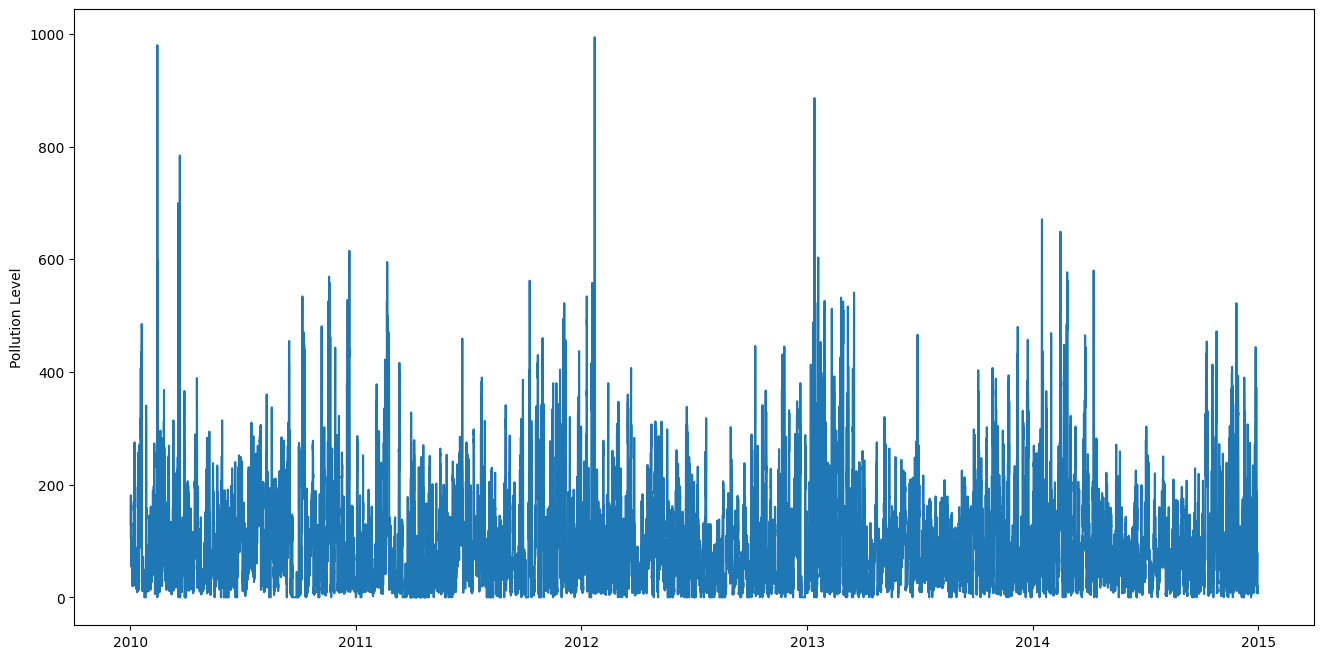

In [3]:
## Plot the timeserie
import matplotlib.pyplot as plt

data['date'] = pd.to_datetime(data['date'])

fig, axs = plt.subplots(1, 1, figsize=(16, 8))

# Plot each variable over time
axs.plot(data['date'], data['pollution'], label='Pollution')
axs.set_ylabel('Pollution Level')

The goal is to forecast pollution levels, and we will use the Mean Square Error (MSE) as the loss function for our MLP model. First, we will split the data into two sets: a training set and a testing set. To avoid overfitting, we will ensure that the split follows the date column to preserve the time dimension. Additionally, to enhance our dataset, we will apply simple data augmentation by incorporating the pollution data from the previous ten days.

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$


In [4]:
## Adding 10 previous values

data_shift=data.copy()

# Shift data
for i in range(1,11):
    data_shift[f't-{i}'] = data_shift["pollution"].shift(i)

# To have not nan
data_shift=data_shift.iloc[10:]
data_shift.reset_index(inplace=True,drop=True)

data_shift.head()


,date,pollution,dew,temp,press,wnd_spd,snow,rain,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,2010-01-02 10:00:00,140.0,-7,-5.0,1026.0,17.43,1,0,132.0,120.0,124.0,105.0,109.0,138.0,181.0,159.0,148.0,129.0
1,2010-01-02 11:00:00,152.0,-8,-5.0,1026.0,20.56,0,0,140.0,132.0,120.0,124.0,105.0,109.0,138.0,181.0,159.0,148.0
2,2010-01-02 12:00:00,148.0,-8,-5.0,1026.0,23.69,0,0,152.0,140.0,132.0,120.0,124.0,105.0,109.0,138.0,181.0,159.0
3,2010-01-02 13:00:00,164.0,-8,-5.0,1025.0,27.71,0,0,148.0,152.0,140.0,132.0,120.0,124.0,105.0,109.0,138.0,181.0
4,2010-01-02 14:00:00,158.0,-9,-5.0,1025.0,31.73,0,0,164.0,148.0,152.0,140.0,132.0,120.0,124.0,105.0,109.0,138.0


In [5]:
## Split the data into train and test (arbitrary we choose the test to be >=2014)

train = data_shift[data_shift["date"].dt.year < 2014]
test = data_shift[data_shift["date"].dt.year == 2014]

In [6]:
## Print shape and get the value to predict (Y) and drop useless columns



y_train=train["pollution"]
X_train=train.drop(["date","pollution"],axis=1)

y_test=test["pollution"]
X_test=test.drop(["date","pollution"],axis=1)

# So we see a input size of 16
print("Train shape : ",X_train.shape)
print("Test shape : ",X_test.shape)

X_train.head()

Train shape :  (35030, 16)
Test shape :  (8760, 16)


,dew,temp,press,wnd_spd,snow,rain,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,-7,-5.0,1026.0,17.43,1,0,132.0,120.0,124.0,105.0,109.0,138.0,181.0,159.0,148.0,129.0
1,-8,-5.0,1026.0,20.56,0,0,140.0,132.0,120.0,124.0,105.0,109.0,138.0,181.0,159.0,148.0
2,-8,-5.0,1026.0,23.69,0,0,152.0,140.0,132.0,120.0,124.0,105.0,109.0,138.0,181.0,159.0
3,-8,-5.0,1025.0,27.71,0,0,148.0,152.0,140.0,132.0,120.0,124.0,105.0,109.0,138.0,181.0
4,-9,-5.0,1025.0,31.73,0,0,164.0,148.0,152.0,140.0,132.0,120.0,124.0,105.0,109.0,138.0


In [7]:
## Create the MLP in Pytorch, in general in Pytorch we create a subclass of nn.module

## For the simplest NN like this you just have to define the constructor and the fordwad method.

## Let's start by a MLP with 2 hidden layers

import torch
import torch.nn as nn
import torch.optim as optim

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) # Input size -> first hidden size
        self.relu1 = nn.ReLU() # Activation fonction
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # first hidden size -> second hidden size
        self.relu2 = nn.ReLU() # Activation fonction
        self.fc3 = nn.Linear(hidden_size2, output_size) # second hidden size -> output size
        # Because we are working with regression task we don't need the last activation function

    def forward(self, x): # Classic feed forwad method
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    

# You can play with these parameters (add also other hidden layer..)
input_size = 16  
hidden_size1 = 8
hidden_size2 = 4
output_size = 1  # For regression, output size is 1 (single continuous value) 

# Create an instance of the MLP model
model = SimpleMLP(input_size, hidden_size1, hidden_size2, output_size)

In [8]:
## Backpropagation code

learning_rate = 0.001
num_epochs = 50


# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optmizer the more used in general

# Very important is to convert your data into torch.tensor object
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# Training loop (very simple)
for epoch in range(1,num_epochs+1):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch%5==0): ## Print loss every 5 epochs
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

c:\Users\Greg\AppData\Local\pypoetry\Cache\virtualenvs\neuralnetworks-ijhHEavh-py3.10\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([35030])) that is different to the input size (torch.Size([35030, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [5/50], Loss: 16661.8438
Epoch [10/50], Loss: 16521.3418
Epoch [15/50], Loss: 16360.5781
Epoch [20/50], Loss: 16175.9238
Epoch [25/50], Loss: 15963.8643
Epoch [30/50], Loss: 15720.8672
Epoch [35/50], Loss: 15443.2852
Epoch [40/50], Loss: 15127.3643
Epoch [45/50], Loss: 14768.5820
Epoch [50/50], Loss: 14357.7900


In [9]:
## As we can see the loss is still decreasing but we want to be careful about overfitting
## So we also compute the loss for the test data (network isn't seeing test data)

new_num_epochs = 300 # This can take some time

# Very important is to convert your data into torch.tensor object
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Initialize lists to store losses
train_losses = []
test_losses = []


for epoch in range(num_epochs+1,num_epochs+new_num_epochs+1):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    outputs_test = model(X_test_tensor)
    loss_test = criterion(outputs_test, y_test_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the losses
    train_losses.append(loss.item())
    test_losses.append(loss_test.item())
    
    if (epoch%50==0): ## Print loss every 10 epochs
        print(f'Epoch [{epoch}/{num_epochs+new_num_epochs}], Loss on train data: {loss.item():.4f}, Loss on test data: {loss_test.item():.4f}')

c:\Users\Greg\AppData\Local\pypoetry\Cache\virtualenvs\neuralnetworks-ijhHEavh-py3.10\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8760])) that is different to the input size (torch.Size([8760, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/350], Loss on train data: 9380.1709, Loss on test data: 9825.6670
Epoch [150/350], Loss on train data: 8858.2461, Loss on test data: 9247.5430
Epoch [200/350], Loss on train data: 8568.5986, Loss on test data: 8911.1611
Epoch [250/350], Loss on train data: 8489.3955, Loss on test data: 8811.8379
Epoch [300/350], Loss on train data: 8472.4844, Loss on test data: 8789.5449
Epoch [350/350], Loss on train data: 8465.3965, Loss on test data: 8781.6738


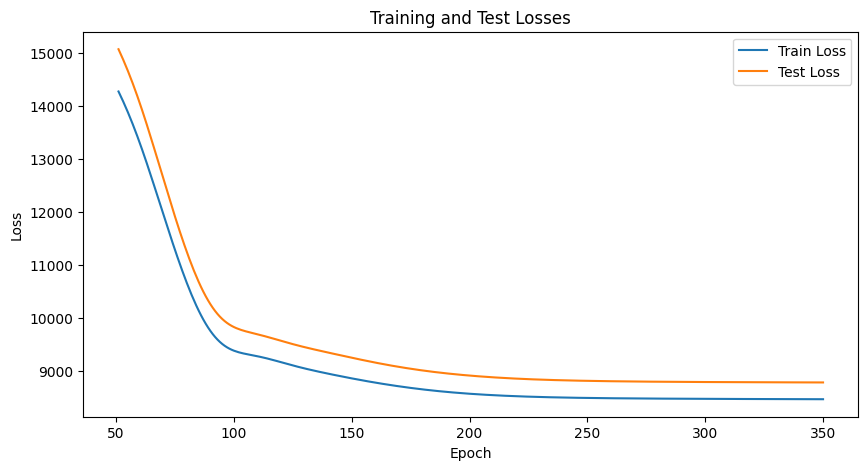

In [10]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs+1, num_epochs+new_num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(num_epochs+1, num_epochs+new_num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

In [12]:
## After analyzing the losses, it's seems like our neural network converges

## How to make a prediciton

real_pollution = y_test.iloc[-1]
predicted_pollution = model(X_test_tensor[-1])

print(f"Real pollution : {real_pollution:.2f}")
print(f"Predicted pollution : {predicted_pollution[0]:.2f}")

## As we can see the result is very bad, you could optimize the features, train more, find more data etc ...

Real pollution : 12.00
Predicted pollution : 105.93
